**Face Mask Detection**

Program Machine Learning untuk mendeteksi penggunaan masker. Program dibuat menggunakan metode CNN dengan arsitektur VGG16Net dan MTCNN untuk face detection.


## Mengimpor Libraries yang dibutuhkan


In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import argparse
import os
import itertools


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.gpu_device_name()

!nvidia-smi




c:\Users\georg\anaconda3\envs\tf\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\georg\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\georg\anaconda3\envs\tf\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Num GPUs Available:  1
Mon Aug 14 11:14:37 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 536.99                 Driver Version: 536.99       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   41C    P0              N/A / ERR! |    140MiB /  3072MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+--

## Preprocessing Datasets


In [3]:
# Inisialisasi nilai Initial Learning Rate, berapa banyak Epoch pelatihan, dan Batch Size
import sys
from PIL import Image

INIT_LR = 1e-4
EPOCHS = 100
BS = 32
 
# Mengambil gambar dari dataset directory, kemudian inisialisasi data dan class gambar
print("Menginput gambar...")

imagePaths = list(paths.list_images('dataset'))
data = []
labels = []
 
# Melakukan perulangan pada image paths
for imagePath in imagePaths:
 
    # Mengekstrak class label dari filename
    label = imagePath.split(os.path.sep)[-2]
    # Memuat input gambar (224x224) dan melakukan proses
    image = load_img(imagePath, target_size=(224, 224))
    image = img_to_array(image)
    image = preprocess_input(image)
 
    # Mengupdate data dan labels lists, berurutan
    data.append(image)
    labels.append(label)
 
# Mengkonversi data dan label ke dalam NumPy Arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)
 
# Melakukan one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print("Input gambar berhasil")

Menginput gambar...


c:\Users\georg\anaconda3\envs\tf\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Input gambar berhasil


### Membuat objek ImageDataGenerator dan Data Augmentation


In [4]:
# Mempartisi data ke dalam pelatihan dan pengujian ( 75% : 25% )
'''
(trainX, testX, trainY, testY) = train_test_split(data, labels,
    test_size=0.25, stratify=labels, random_state=42)
 '''


# Membentuk training image generator untuk data augmentation
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

## Membuat Model Jaringan CNN yang sudah dipelajari sebelumnya (pre-trained convnets)


In [5]:
# Arsitektur jaringan VGG16Net
baseModel = tf.keras.applications.VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

### Feature Extraction


In [6]:
baseModel.trainable = False
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Tahap Pembuatan Model


In [7]:
# Membentuk bagian head dari model yang akan ditempatkan pada base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
 
# Menempatkan head model pada base model
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     


                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)       295168    
                                                                 
 block3_conv2 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_conv3 (Conv2D)       (None, 56, 56, 256)       590080    
                                                                 
 block3_po

In [8]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle =True)

(train_data, test_data, train_labels, test_labels) = train_test_split(data, labels,
    test_size=0.20, stratify=labels, random_state=42)




fold_accuracies = []
 
# Perulangan pada seluruh base model
fold = 1
for train_index, test_index in kf.split(data):
  print("Mengkompilasi model...")
  print("fold", fold)
 
 
 
  train_data, train_labels = data[train_index], labels[train_index]
  test_data, test_labels = data[test_index], labels[test_index]
  
  
  opt = tf.keras.optimizers.legacy.Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
  
  model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
  #model.summary()

  print("Training head model...")

  H = model.fit(
    aug.flow(train_data, train_labels, batch_size=BS),
    steps_per_epoch=len(train_data) // BS,
    validation_data=(test_data, test_labels),
    validation_steps=len(test_data) // BS,
    epochs=EPOCHS)
  
  '''
  H = model.fit(aug.flow(train_data,
          steps_per_epoch=len(train_data) // BS,
          validation_data=test_data,
          epochs=10))
  '''
  loss, accuracy = model.evaluate(test_data, test_labels, verbose = 0)
  
  fold_accuracies.append(accuracy)

  fold+=1
  
'''
INIT_LR = 1e-4
EPOCHS = 30
BS = 32
'''  
# H = model.fit(aug.flow(train_data, train_labels, epochs = 10, batch_size = 32, verbose=0))


#for layer in baseModel.layers:
    #layer.trainable = False
 
# Persiapan kompilasi model


Mengkompilasi model...
fold 1
Training head model...
Epoch 1/100
95/95 [==============================] - 83s 717ms/step - loss: 0.6587 - accuracy: 0.6414 - val_loss: 0.5593 - val_accuracy: 0.9179
Epoch 2/100
95/95 [==============================] - 45s 468ms/step - loss: 0.5489 - accuracy: 0.8078 - val_loss: 0.4602 - val_accuracy: 0.9361
Epoch 3/100
95/95 [==============================] - 45s 467ms/step - loss: 0.4630 - accuracy: 0.8813 - val_loss: 0.3753 - val_accuracy: 0.9465
Epoch 4/100
95/95 [==============================] - 45s 469ms/step - loss: 0.3962 - accuracy: 0.9061 - val_loss: 0.3112 - val_accuracy: 0.9505
Epoch 5/100
95/95 [==============================] - 45s 470ms/step - loss: 0.3331 - accuracy: 0.9249 - val_loss: 0.2669 - val_accuracy: 0.9478
Epoch 6/100
95/95 [==============================] - 45s 470ms/step - loss: 0.3022 - accuracy: 0.9219 - val_loss: 0.2288 - val_accuracy: 0.9544
Epoch 7/100
95/95 [==============================] - 43s 455ms/step - loss: 0.2657 

ResourceExhaustedError: Graph execution error:

Detected at node 'model/block1_conv2/Relu' defined at (most recent call last):
    File "c:\Users\georg\anaconda3\envs\tf\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\georg\anaconda3\envs\tf\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\traitlets\config\application.py", line 992, in launch_instance
      app.start()
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\georg\anaconda3\envs\tf\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "c:\Users\georg\anaconda3\envs\tf\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "c:\Users\georg\anaconda3\envs\tf\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\IPython\core\interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\georg\AppData\Local\Temp\ipykernel_12072\860264005.py", line 32, in <module>
      H = model.fit(
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1606, in fit
      val_logs = self.evaluate(
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1665, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\layers\convolutional\base_conv.py", line 314, in call
      return self.activation(outputs)
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\activations.py", line 317, in relu
      return backend.relu(
    File "c:\Users\georg\anaconda3\envs\tf\lib\site-packages\keras\backend.py", line 5366, in relu
      x = tf.nn.relu(x)
Node: 'model/block1_conv2/Relu'
OOM when allocating tensor with shape[34,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_52242]

### Melakukan Pelatihan Model


In [19]:
# Pelatihan model
mean_accuracy = np.mean(accuracy)
print(mean_accuracy*100)
print(accuracy)

95.95300555229187
0.9595300555229187


## Menampilkan Grafik Model Hasil Pelatihan


In [23]:
epoch_accs = np.array(fold_accuracies)

plt.figure(figsize=(7, 4))
for fold in range(epoch_accs.shape[0]):
    plt.plot(range(1, epoch_accs.shape[1]+1), epoch_accs[fold], label=f"Fold {fold+1}")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch - K-Fold Cross Validation')
plt.legend()
plt.show()

IndexError: tuple index out of range

<Figure size 700x400 with 0 Axes>

ValueError: x and y must have same first dimension, but have shapes (30,) and (2,)

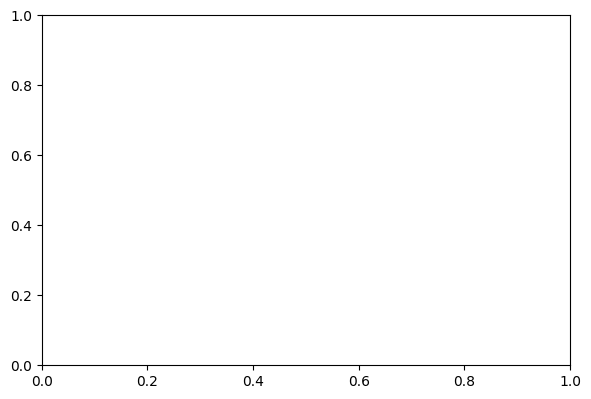

In [21]:
N = 2
#N = EPOCHS
fig = plt.figure(figsize=(7, 4))
fig.set_figheight(10)
fig.set_figwidth(15)
 
plt.subplot(2, 2, 1)
plt.plot(np.arange(0, N), H.history["accuracy"],label = "Training Accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"],label = "Validation Accuracy")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Akurasi")
plt.title("Kurva Tingkat Akurasi", size=15)
plt.grid(zorder = 0)
 
plt.subplot(2, 2, 2)
plt.plot(np.arange(0, N), H.history["loss"],label = "Training Loss")
plt.plot(np.arange(0, N), H.history["val_loss"],label = "Validation Loss")
plt.legend()
plt.xlabel("Epoch #")
plt.ylabel("Error")
plt.title("Kurva Tingkat Error", size=15)
plt.grid(zorder = 0)
plt.show()

## Evaluasi Jaringan


In [24]:
# Memeriksa matriks model
print(model.metrics_names)
# Evaluasi data test
'''
print(model.evaluate(x= testX, y = testY))
'''

print(model.evaluate(x= train_data, y = train_labels))
# evaluasi fold



['loss', 'accuracy']
96/96 [==============================] - 753s 8s/step - loss: 0.1480 - accuracy: 0.9641
[0.14803509414196014, 0.9641343355178833]


In [25]:
# Menampilkan matriks yang benar dan matriks hasil prediksi
# Label yang benar
yTrue = np.argmax(train_labels, axis=1)

# Label prediksi
YPred = model.predict(train_data, batch_size=BS)
yPred = np.argmax(YPred, axis=1)

print(yTrue)
print(yPred)

96/96 [==============================] - 759s 8s/step
[1 1 1 ... 0 0 0]
[0 1 1 ... 0 0 0]


## Confusion Matrix


In [26]:
def get_confusion_matrix(yTrue, yPred):
    n_classes = len(np.unique(yTrue)) 
    conf = np.zeros((n_classes, n_classes))
    for actual, pred in zip(yTrue, yPred):
        conf[int(actual)][int(pred)] += 1
    return conf.astype('int')

In [27]:
conf = get_confusion_matrix(yTrue, yPred)
conf

array([[1485,   59],
       [  51, 1472]])

Text(0.5, 23.52222222222222, 'Label Prediksi')

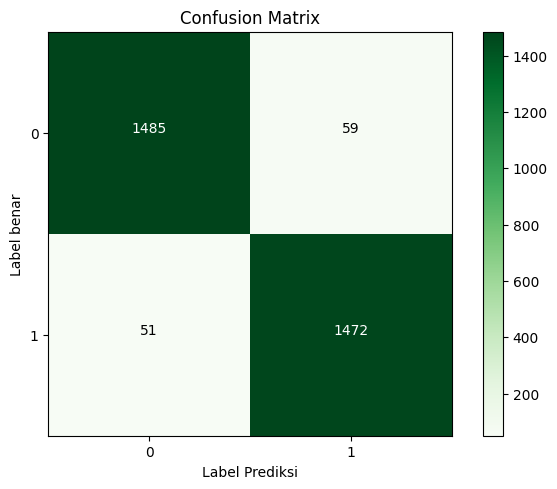

In [28]:
classes = [0, 1]
# Plot confusion matrix
plt.imshow(conf, interpolation='nearest', cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

fmt = 'd'
thresh = conf.max() / 2.
for i, j in itertools.product(range(conf.shape[0]), range(conf.shape[1])):
    plt.text(j, i, format(conf[i, j], fmt),
             horizontalalignment="center",
             color="white" if conf[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('Label benar')
plt.xlabel('Label Prediksi')

Analisis mAP


In [ ]:
# Berdasarkan confusion matrix
TP = true_pos = 366
TN = true_neg = 380
FP = false_pos = 17
FN = false_neg = 4

time: 973 µs (started: 2023-05-05 03:20:09 +00:00)


In [ ]:
results = {}

# Akurasi
metric = "Akurasi"
results[metric] = (TP + TN) / (TP + TN + FP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Recall
metric = "Recall"
results[metric] = TP / (TP + FN)
print(f"{metric} = {results[metric]: .3f}")

# Presisi
metric = "Presisi"
results[metric] = TP / (TP + FP)
print(f"{metric} = {results[metric]: .3f}")

# Nilai F1
metric = "F1"
results[metric] = 2 / (1 / results["Presisi"] + 1 / results["Recall"])
print(f"{metric} = {results[metric]: .3f}")

Akurasi =  0.973
Recall =  0.989
Presisi =  0.956
F1 =  0.972
time: 6.78 ms (started: 2023-05-05 03:20:11 +00:00)


In [29]:
# Membuat prediksi dari pengujian
predIdxs = model.predict(train_data, batch_size=BS)
 
# Untuk setiap gambar dalam set pengujian, kita perlu menemukan indeks label
# dengan probabilitas prediksi terbesar
predIdxs = np.argmax(predIdxs, axis=1)
 
# Menampilkan laporan klasifikasi yang diformat dengan baik
print(classification_report(train_labels.argmax(axis=1), predIdxs,
    target_names=lb.classes_))

96/96 [==============================] - 723s 8s/step
              precision    recall  f1-score   support

   with_mask       0.97      0.96      0.96      1544
without_mask       0.96      0.97      0.96      1523

    accuracy                           0.96      3067
   macro avg       0.96      0.96      0.96      3067
weighted avg       0.96      0.96      0.96      3067



## Menyimpan dan Konversi Model ke ".tflite"

Menyimpan model menggunakan tf.saved_model/save dan kemudian mengkonversi model tersimpan ke format yang kompatibel tf lite.


In [30]:
export_dir='saved_model/1'
tf.saved_model.save(model, export_dir)

INFO:tensorflow:Assets written to: saved_model/1\assets


INFO:tensorflow:Assets written to: saved_model/1\assets


In [31]:
# Mengkonvert model ke format tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [33]:
# Menyimpan model
tflite_model_file = pathlib.Path('face-mask-detection/content/model.tflite')
tflite_model_file.write_bytes(tflite_model)

59131992

In [34]:
# Memuat model dan mengalokasikan ke tensor
interpreter = tf.lite.Interpreter(model_content = tflite_model)
interpreter.allocate_tensors()

# Mendapatkan input dan ouput tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

print(input_details)
print(output_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 224, 224,   3]), 'shape_signature': array([ -1, 224, 224,   3]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 54, 'shape': array([1, 2]), 'shape_signature': array([-1,  2]), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


# Pengujian Model dengan MTCNN


Model diujikan pada gambar dan secara real-time dengan menggunakan MTCNN yang digunakan untuk mendeteksi wajah.


In [1]:
!pip install mtcnn

  Using cached mtcnn-0.1.1-py3-none-any.whl (2.3 MB)
  Using cached opencv_python-4.7.0.72-cp37-abi3-win_amd64.whl (38.2 MB)


## Penggunaan Model pada Gambar


In [2]:
from mtcnn import MTCNN
import cv2
#from google.colab.patches import cv2_imshow

In [43]:
detector = MTCNN()
image = cv2.imread('face-mask-detection/example_img/ex04.jpg', cv2.COLOR_BGR2RGB)
faces = detector.detect_faces(image)
for result in faces:
    x, y, w, h = result['box']
    x1, y1 = x + w, y + h
    
    # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
    # dan mengubah ukurannya menjadi 224x224, dan lalu pre-proses
    face = image[y:y1, x:x1]
    face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)
    face = np.expand_dims(face, axis=0)    

    # Membaca wajah dengan model
    (mask, withoutMask) = model.predict(face)[0]

    # Menggunakan masker hijau, tidak bermasker merah
    label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
    color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

		# Probabilitas hasil deteksi
    label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

    # Menampilkan hasil dengan label dan kotak
    cv2.putText(image, label, (x, y - 10),
    cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (x, y), (x1, y1), color, 2)

# Menampilkan output
cv2.imshow(" Hasil", image)
cv2.waitKey(0)

1/1 [==============================] - 0s 276ms/step


-1

## Pengujian Deteksi Perframe Capture


In [ ]:
# Mengimport lib
from mtcnn import MTCNN
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
from IPython.display import display, Javascript
from google.colab.output import eval_js
from PIL import Image
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import base64
import html
import io
import time

In [ ]:
def start_input():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }
      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);
      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Ketika selesai, klik disini atau pada video untuk berhenti dari demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();
      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function takePhoto(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }
      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')
 
  display(js)
  
def take_photo(label, img_data):
  data = eval_js('takePhoto("{}", "{}")'.format(label, img_data))
  return data

In [ ]:
def js_reply_to_image(js_reply):
    """
    input: 
          js_reply: JavaScript object, contain image from webcam
    output: 
          image_array: image array RGB size 512 x 512 from webcam
    """
    jpeg_bytes = base64.b64decode(js_reply['img'].split(',')[1])
    image_PIL = Image.open(io.BytesIO(jpeg_bytes))
    image_array = np.array(image_PIL)
 
    return image_array

In [ ]:
start_input()
label_html = 'Capturing...'
img_data = ''
count = 0 

# Menginisialisasi MTCNN
detector = MTCNN()

from google.colab.patches import cv2_imshow
while True:
  js_reply = take_photo(label_html, img_data)
  if not js_reply:
    break
    
  image = js_reply_to_image(js_reply)

	# Mengambil frame dari aliran video berulir dan 
  # ukurannya maksimum lebar 400 pixel
  frame = image
  v=True
  if v == True:

    frame = imutils.resize(frame, width=400)

    faces = detector.detect_faces(frame)
    faces_list = []
    preds = []
    for result in faces:
      x, y, w, h = result['box']
      x1, y1 = x + w, y + h

      # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
      # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
      face = image[y:y1, x:x1]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
     
      faces_list.append(face)
      
      if len(faces_list) > 0:
        preds = model.predict(faces_list)
    
      # Mendeteksi bermasker atau tidak
      for pred in preds:
        (mask, withoutMask) = pred

	  	# Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (0, 0, 255)

	  	# Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

	  	# Menampilkan hasil dengan label dan kotak dari frame
      frame=cv2.putText(frame, label, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      frame=cv2.rectangle(frame, (x, y), (x1, y1), color, 2)

	# Menampilkan ouput
      cv2_imshow(frame)

## Pengujian Streaming Video


In [ ]:
# import dependencies
from mtcnn import MTCNN
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 512, 512);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 512; //video.videoWidth;
      captureCanvas.height = 512; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# Memulai streaming video dari webcam
video_stream()
# Label untuk video
label_html = 'Capturing...'
bbox = ''
count = 0 
# Menginisialisasi MTCNN
detector = MTCNN()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # Mengkonvert JS response ke OpenCV Image
    img = js_to_image(js_reply["img"])
    
    # Membuat transparan overlay untuk bounding box
    bbox_array = np.zeros([512,512,4], dtype=np.uint8)

    faces = detector.detect_faces(img)
    faces_list = []
    preds = []

    for result in faces:
      x, y, w, h = result['box']
      x1, y1 = x + w, y + h
      
      # Ekstrak ROI wajah, konversikan dari BGR ke pemesanan saluran RGB,
      # dan mengubah ukurannya menjadi 224x224, dan lalu pre-prosess
      face = image[y:y1, x:x1]
      face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
      face = cv2.resize(face, (224, 224))
      face = img_to_array(face)
      face = preprocess_input(face)
      face = np.expand_dims(face, axis=0)
     
      faces_list.append(face)
      
      if len(faces_list) > 0:
        preds = model.predict(faces_list)
    
      # Mendeteksi bermasker atau tidak
      for pred in preds:
        (mask, withoutMask) = pred

		  # Menggunakan masker hijau, tidak bermasker merah
      label = "Bermasker" if mask > withoutMask else "Tidak Bermasker"
      color = (0, 255, 0) if label == "Bermasker" else (255, 0, 0)

		  # Probabilitas pada label
      label = "{}: {:.2f}%".format(label, max(mask, withoutMask) * 100)

		  # Menampilkan hasil dengan label dan kotak dari frame
      bbox_array=cv2.putText(bbox_array, label, (x, y - 10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      bbox_array=cv2.rectangle(bbox_array, (x, y), (x1, y1), color, 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255

    # Mengkonversi overlay bbox ke dalam bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
 
    # Mengupdate bbox ke pada frame selanjutnya untuk mendapat overlay
    bbox = bbox_bytes